### 1. Libraries & Function


In [34]:
import os
import warnings
import logging
import pandas as pd
import matplotlib.pyplot as plt
from oemof.solph import (Bus, EnergySystem, Flow, Model, create_time_index, processing)
from oemof.solph.components import (Sink, Source, Converter, GenericStorage)
from oemof.solph import EnergySystem
from oemof.solph import views
import oemof.solph as solph
import pandas as pd

def LCOH(invest_cost, operation_cost, heat_produced, revenue=0, i=0.05, n=20):
    pvf = ((1 + i) ** n - 1) / ((1 + i) ** n * i)
    return (invest_cost + pvf * (operation_cost - revenue)) / (
        pvf * heat_produced
    )
def epc(invest_cost, i=0.05, n=20):
    af = (i * (1 + i) ** n) / ((1 + i) ** n - 1)
    return invest_cost * af

filename = r"OEMOF_files/input_data.csv"
data = pd.read_csv(filename)
solver = "cbc"
solver_verbose = False

print(data.columns.tolist())

['thermal_demand_MW', 'electricity_price_Euro_Per_MWh', 'co2_price', 'gas_price_Euro_Per_MWh', 'biomass_Euro_Per_MWh']


### 2. Energy System

In [ ]:
datetimeindex = create_time_index(2023, number=len(data)) 
energysystem = EnergySystem(timeindex=datetimeindex, infer_last_interval=False)

electrical_bus = Bus(label="electrical_bus") # Electricity bus
thermal_bus = Bus(label="thermal_bus") # Heat bus
gas_bus = Bus(label="gas_bus") # Natural gas bus
biomass_bus = Bus(label="biomass_bus") # Biomass bus
waste_bus = Bus(label="waste_bus") # Municipal Waste bus
wasteheat_bus = Bus(label="wasteheat_bus") # Waste Heat bus
# solar_bus = Bus(label="solar_bus") # Solar bus
energysystem.add(electrical_bus, thermal_bus, gas_bus, biomass_bus, waste_bus, wasteheat_bus)

#============================== SOURCES =============================#
energysystem.add(
    Source(label="natural_gas",outputs={gas_bus: Flow(variable_costs=data["gas_price_Euro_Per_MWh"])})
                )
energysystem.add(
    Source(label="electricity_grid",outputs={electrical_bus: Flow(variable_costs=data["electricity_price_Euro_Per_MWh"])})
                )
energysystem.add(
    Source(label="biomass",outputs={biomass_bus: Flow(variable_costs=data["biomass_Euro_Per_MWh"])})
                )
energysystem.add(
    Source(label="waste",outputs={biomass_bus: Flow(variable_costs=data["waste_Euro_Per_MWh"])})
                )
energysystem.add(
    Source(label="waste_heat",outputs={wasteheat_bus: Flow(variable_costs=0)})
                )

#============================== LOAD =============================#
thermal_peak = data["thermal_demand_MW"].max()
energysystem.add(
    Sink(
        label="thermal_demand",
        inputs={thermal_bus: Flow(
            nominal_value=thermal_peak,
            fix=data["thermal_demand_MW"] / thermal_peak
        )},
    )
)
energysystem.add(
    Sink(
        label="excess_electricity",
        inputs={electrical_bus: Flow(variable_costs=data["electricity_price_Euro_Per_MWh"] * -1)}
    )
)
#============================== CONVERTERS =============================#
# 1. Gas Turbine Combined Heat and Power (CHP) units
energysystem.add(
    Converter(
        label='chp_gas',
            inputs={gas_bus: Flow()},
            outputs={   electrical_bus: Flow(nominal_value=3),
                        thermal_bus: Flow(nominal_value=5)},
            conversion_factors={    electrical_bus: 0.3, thermal_bus: 0.4,
                                    gas_bus: 0.9}
    )
)
# 2. Biomass Combined Heat and Power (CHP) units
energysystem.add(
    Converter(
        label='chp_biomass',
            inputs={biomass_bus: Flow()},
            outputs={   electrical_bus: Flow(nominal_value=10),
                        thermal_bus: Flow(nominal_value=20)},
            conversion_factors={    electrical_bus: 0.3, thermal_bus: 0.4,
                                    biomass_bus: 0.9}
    )
)
#3. Waste to Energy Plant
energysystem.add(
    Converter(
        label='waste_to_energy',
            inputs={waste_bus: Flow()},
            outputs={   electrical_bus: Flow(nominal_value=8),
                        thermal_bus: Flow(nominal_value=12)},
            conversion_factors={    electrical_bus: 0.4, thermal_bus: 0.6,
                                    waste_bus: 1.0}
    )
)
# 4. Heat Pump
cop_hp = 3.5
energysystem.add(
    Converter(
        label="heat_pump",
        inputs={
            electrical_bus: Flow(),      # electricity input
            wasteheat_bus: Flow(),       # low-temperature / source heat
        },
        outputs={
            thermal_bus: Flow(nominal_value=15),  # max thermal capacity [MW]
        },
        conversion_factors={
            # electrical input: 1 / COP
            electrical_bus: 1 / cop_hp,
            # heat source input: (COP - 1) / COP
            wasteheat_bus: (cop_hp - 1) / cop_hp,
        },
    )
)

#============================== OPTIMIZE =============================#
model = Model(energysystem,name="District Heating Optimization Model")
logging.info("Solving the optimization problem.")
model.solve(
    solver='cbc',
    solve_kwargs={"tee": True},
    cmdline_options={"ratioGap": "0.02"}
)


energysystem.results["main"] = processing.results(model)
energysystem.results["meta"] = processing.meta_results(model)
output_file = os.path.join(os.getcwd(), "Outputs/results.oemof")
energysystem.dump(os.getcwd(), "Outputs/results.oemof")
logging.info("Results have been dumped.")
results = energysystem.results["main"]

electrical_bus_view = views.node(results, "electrical_bus")
thermal_bus_view    = views.node(results, "thermal_bus")
gas_bus_view        = views.node(results, "gas_bus")
biomass_bus_view    = views.node(results, "biomass_bus")
print(thermal_bus_view)

Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Jul 31 2025 

command line - C:\Users\ardia\miniconda3\envs\env_P2\Library\bin\cbc.exe -ratioGap 0.02 -printingOptions all -import C:\Users\ardia\AppData\Local\Temp\tmpxaegxq7y.pyomo.lp -stat=1 -solve -solu C:\Users\ardia\AppData\Local\Temp\tmpxaegxq7y.pyomo.soln (default strategy 1)
ratioGap was changed from 0 to 0.02
Option for printingOptions changed from normal to all
Presolve 0 (-70080) rows, 0 (-87600) columns and 0 (-157680) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type R

c:\Users\ardia\miniconda3\envs\env_P2\lib\site-packages\oemof\network\energy_system.py:256: FutureWarning: Parameter 'dpath' will be removed in a future version. You can give the directory as part of the filename and set 'consider_dpath' to False to suppress this waring.
  warnings.warn(


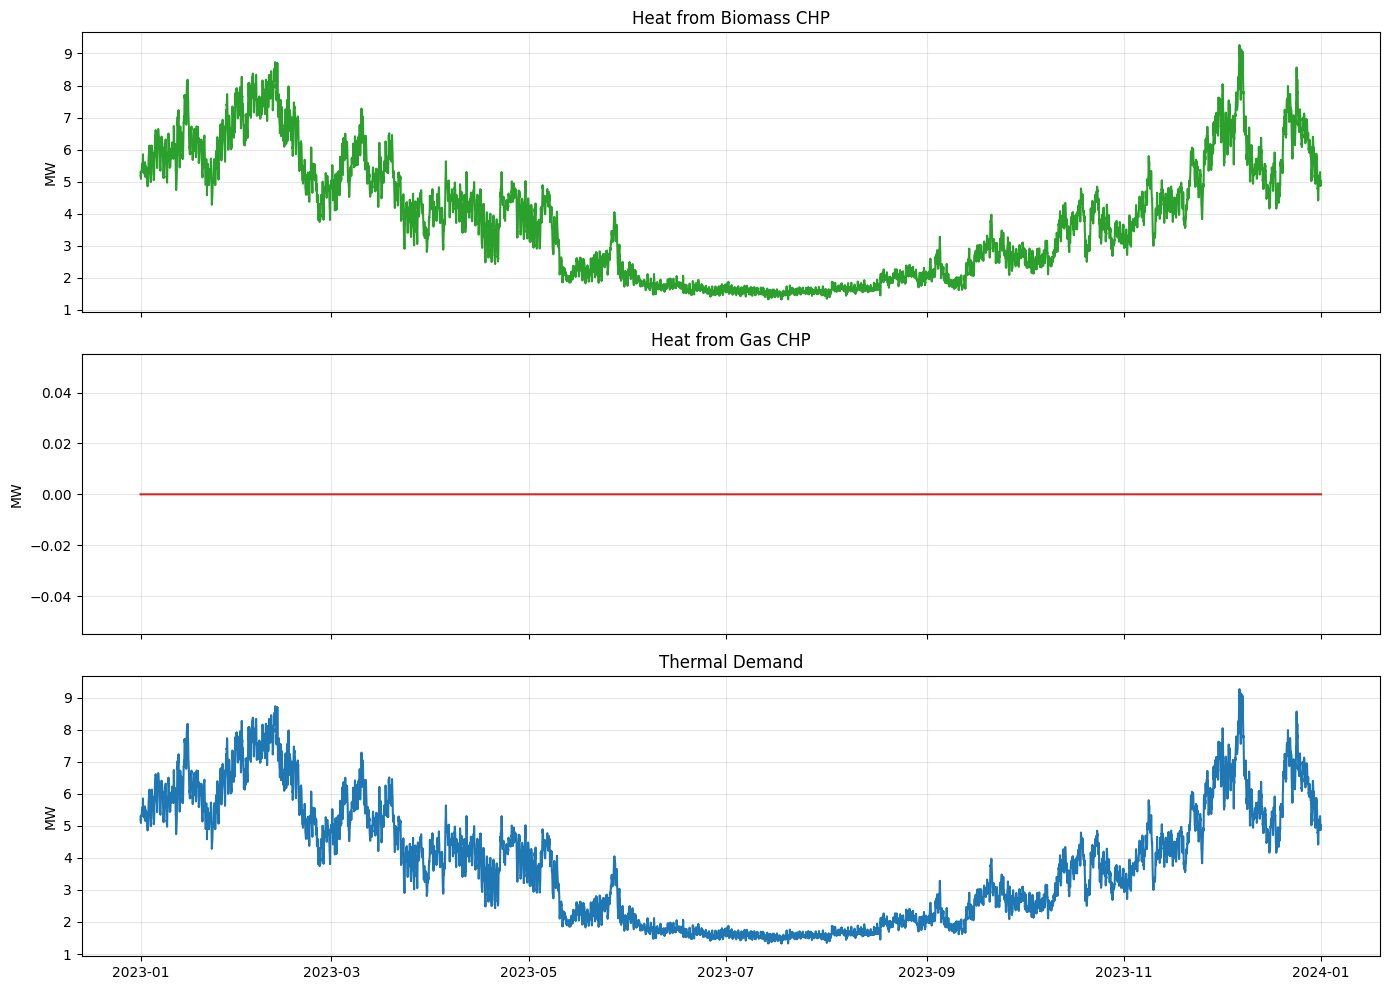

In [45]:
import matplotlib.pyplot as plt
from oemof.solph import views

# Get thermal bus results
thermal_bus_view = views.node(results, "thermal_bus")

# Drop the last NaN row (2024-01-01)
seq = thermal_bus_view["sequences"].iloc[:-1]

# Column names exactly as in results
col_biomass = (("chp_biomass", "thermal_bus"), "flow")
col_gas     = (("chp_gas", "thermal_bus"), "flow")
col_demand  = (("thermal_bus", "thermal_demand"), "flow")

# --- 3 subplots in one figure ---
fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# 1. Biomass CHP heat
axs[0].plot(seq[col_biomass], color="tab:green")
axs[0].set_title("Heat from Biomass CHP")
axs[0].set_ylabel("MW")
axs[0].grid(True, alpha=0.3)

# 2. Gas CHP heat
axs[1].plot(seq[col_gas], color="tab:red")
axs[1].set_title("Heat from Gas CHP")
axs[1].set_ylabel("MW")
axs[1].grid(True, alpha=0.3)

# 3. Heat demand
axs[2].plot(seq[col_demand], color="tab:blue")
axs[2].set_title("Thermal Demand")
axs[2].set_ylabel("MW")
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [44]:
import pandas as pd
from pyomo.opt import TerminationCondition, SolverStatus

meta = energysystem.results["meta"]

print("\n==================== META RESULTS ====================\n")

# Objective
print(f"Objective value             : {float(meta['objective']):,.3f}")

# Problem information
problem = meta.get("problem", {})
print("\n--- Problem Structure ---")
print(f"Name                        : {problem.get('Name')}")
print(f"Constraints                 : {problem.get('Number of constraints'):,}")
print(f"Variables                   : {problem.get('Number of variables'):,}")
print(f"Nonzeros                    : {problem.get('Number of nonzeros'):,}")
print(f"Sense                       : {problem.get('Sense').name}")

# Solver information
solver = meta.get("solver", {})
print("\n--- Solver Information ---")
print(f"Status                      : {solver.get('Status').name}")
print(f"Termination condition       : {solver.get('Termination condition').name}")
print(f"Termination message         : {solver.get('Termination message')}")
print(f"User time (s)               : {solver.get('User time')}")
print(f"System time (s)             : {solver.get('System time')}")
print(f"Wallclock time (s)          : {solver.get('Wallclock time')}")
print(f"Reported Time (Pyomo) (s)   : {solver.get('Time')}")

print("\n======================================================\n")



==================== META RESULTS ====================

Objective value             : 420,107.176

--- Problem Structure ---
Name                        : unknown
Constraints                 : 70,080
Variables                   : 87,600
Nonzeros                    : 0
Sense                       : minimize

--- Solver Information ---
Status                      : ok
Termination condition       : optimal
Termination message         : Model was solved to optimality (subject to tolerances), and an optimal solution is available.
User time (s)               : -1.0
System time (s)             : 0.57
Wallclock time (s)          : 0.57
Reported Time (Pyomo) (s)   : 0.6810705661773682


